In [19]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

In [20]:
import importlib

# 2 | Prevalence of communication failures by age 

Requires Levenhstein distances from "Levenshtein distance in Providence.ipynb", saved under 'csv/pvd_levdist.csv'.

In [12]:
from yyy_analysis import get_communication_analysis_data

In [14]:
importlib.reload(yyy_analysis)

chi_phono = get_communication_analysis_data.get_communication_failures_data(verbose = True)

# Verbose output verified on 6/24/21

R[write to console]: Using current database version: '2020.1'.

R[write to console]: Using supported database version: '2020.1'.



Providence    396621
Name: corpus_name, dtype: int64

*           26736
ə              10
(.)             7
aɪ              4
hiɡh            2
            ...  
neɪniwɑə        1
hɛʔ             1
pʊ              1
ɛaɪə            1
ɪddə            1
Name: actual_phonology, Length: 76, dtype: int64
ɛ          3206
ʌ          2132
ɪ          1881
ə           512
o           507
           ... 
mɑmɑːw        1
dɑːtɪ         1
lʊkɪt         1
n̩næŋnə       1
əwɔf          1
Name: actual_phonology, Length: 30293, dtype: int64
(31457, 3)
(83880, 3)
(214239, 12)

1          ɑmɪ
3          wiː
4          wiː
5           uː
52           ɛ
          ... 
396606       o
396607     waɪ
396608     liʔ
396609       ɪ
396610    hɪpo
Name: actual_phonology, Length: 214239, dtype: object
(369789, 12)


In [15]:
error_codes = ('yyy')

In [21]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

In [22]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

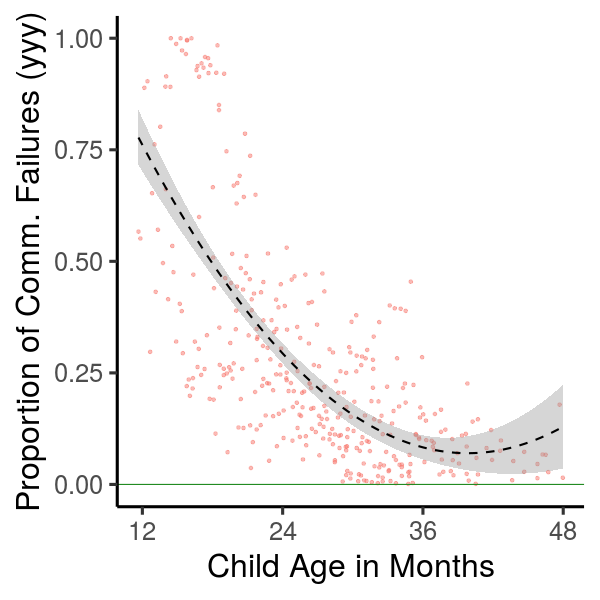

In [23]:
%%R -w 600 -h 600

pvd_comm_error = subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')

pvd_comm_error$age_in_months = pvd_comm_error$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

ggplot(pvd_comm_error) + geom_point(aes(x=target_child_age_months, 
y=proportion_errors, color= "collection_name"), alpha=.5) + theme_classic(base_size =32) + xlab('Child Age in Months') + ylab(
'Proportion of Comm. Failures (yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors),  linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black')  + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months) + geom_hline(yintercept=0,
    color = "forestgreen") +theme(legend.position="none")

## Require the pvd_levdist.csv generation code to refactor properly -- it's not in the latest Levenshtein distance code

In [ ]:
%%R
# Data for Lvenshtin distances in Providence comes from notebook "Levenshtein distance in Providence"
chi_levdist = read.csv('csv/pvd_levdist.csv')

In [ ]:
%%R -h 600 -w 600
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

p1 = ggplot(subset(chi_levdist, mean_levdist < 100 & corpus_name == 'Providence')) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + theme_classic(base_size = 32) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Articulation Error"
) + xlab('Child Age (Months)') + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
print(p1)

In [ ]:
%%R
chi_levdist$age_in_months = NULL
pvd_comm_error_merged = merge(pvd_comm_error, chi_levdist,
        by=c('transcript_id'))
nrow(pvd_comm_error_merged)

In [ ]:
%%R -w 600 -h 600
names(pvd_comm_error_merged)

p1 = ggplot(pvd_comm_error_merged) + geom_point(aes(x=mean_levdist, y=proportion_errors, 
color=age_in_months), alpha=.5)  + theme_classic(base_size = 32
)  + coord_cartesian(ylim=c(0,1), xlim =c(0,1)) + scale_color_viridis_c(
) + ylab('Proportion of Comm. Failures (yyy)') + xlab('Articulation Error'
) + theme(legend.position=c(.3, .7), legend.background=element_blank()) + labs(color = "Age in Months") 

print(p1)


In [ ]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

In [ ]:
# Manually confirm that these transcripts indeed have a very high proportion of errors
# Was not yet done for the refactor, but refactor code is basically same for this section as the original.